In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
import os
from copy import deepcopy
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
cpu = torch.device('cpu')
#"cuda:0" if torch.cuda.is_available() else "cpu")
dv=torch.device('cuda')
#torch.device("cuda" if torch.cuda.is_available() else "cpu")import torchmetrics
import torchmetrics
acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

In [3]:
import time

In [4]:
from load_pums import load_data,get_default_meta

In [5]:
from model_class import MTL,Branched_model
from my_util import DM_rate, branches,fair_loss,find_groups,sim_mat,get_grads,fair_grads,get_conflicts
from my_util import get_task_heats

## FairBranch train on ACS-PUMS

In [9]:
def trainFB(year='2018',tau=None,ablation=False,meta=False,clustering='agglomerative'):
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
    X_train, X_val,in_tr,in_val,y_train,y_v,g_train,g_val='','','','','','','',''
    dir_path='/yourpath/Grouping_FMTL/models/'
    dataset='PUMS_'
    if ablation==True:
        dir_path=dir_path+'ablation/'+str(tau)
    prefix=dir_path+dataset+'_'+year+'_'
        
    path=prefix+'fB.pt'
    path_br=prefix+'branches.pt'
    path_task=prefix+'task_layers.pt'
    path_sh=prefix+'sh_layers.pt'
    path_par=prefix+'parents.pt'
    
    states=['CA','FL','GA','AL','AZ','AR','CO',
            'CT','IL','IN','IA','KS','LA','MD','MA','MI',
            'MN','MO','NY','NC','OH',
       'OR','PA','TX','VA','WA','WI']
    features,tasks=get_default_meta()
    N_tasks=len(tasks)
    shapes=[1024,128,256,512,128]
    depth=len(shapes)
    fb=nn.DataParallel(MTL(d_in=len(features),tasks=N_tasks,shapes=shapes).to(dv))
    fb.to(dv)
    opti_S=optim.AdamW(params=fb.parameters())
    criteria = nn.CrossEntropyLoss()
    
    parents={i:[] for i in range(N_tasks)}
    out=1
    branch_layers=nn.ModuleDict()
    groups=[[i for i in range(N_tasks)]]
    grouped={}
    
    
    fconflict_heats=torch.zeros(N_tasks,N_tasks)
    aconflict_heats=torch.zeros(N_tasks,N_tasks)
    fconflicts=[]
    aconflicts=[]
    abest,fbest= 10**5,10**5

    j=0
    for epoch in range(15):  # loop over each state multiple times
        st_all=deepcopy(states)
        cntr=[[],[]]
        for k in range(len(states)):
            st=np.random.choice(st_all)
            st_all.remove(st)
            if meta==True:
                print('State',st)
            del X_train, X_val,in_tr,in_val,y_train,y_v,g_train,g_val
            X_train, X_val,in_tr,in_val,y_train,y_v,g_train,g_val=load_data(
                mode='train',year=year,state_list=[st])
            xg=torch.tensor(g_train)
            i,batch=0,8192
            while(i<len(X_train)):
                if (i+batch)<len(X_train):
                    inputs, in_t = torch.tensor(X_train[i:i+batch]),in_tr[i:i+batch]
                    labels=[y_train[t][i:i+batch] for t in range(N_tasks)]
                    xc=xg[i:i+batch]
                    i=i+batch 
                else:
                    inputs,in_t = torch.tensor(X_train[i:]),in_tr[i:]
                    labels=[y_train[t][i:] for t in range(N_tasks)]
                    xc=xg[i:]
                    i=len(X_train)

                # empty the parameter gradients          
                opti_S.zero_grad()
                outputs = fb(inputs.to(dv).float())
                if len(grouped)>0: #to be applied on branches after formation of branches
                    fb=fair_grads(fb,outputs,labels,xc,grouped,dv)
                for t in range(N_tasks):            
                    loss_a=criteria(outputs[t], labels[t].to(dv))            
                    loss_a.backward(retain_graph=True)
                opti_S.step()

            #collect gradients for ploting conflicts
            opti_S.zero_grad()
            pred0=fb(torch.tensor(X_val).to(dv).float())
            #start = time.time()
            task_grads=[]
            for t in range(N_tasks):
                loss_f=fair_loss(pred0[t], 
                                 torch.tensor(y_v[t]).to(dv),
                                 torch.tensor(g_val).to(dv))
                loss_f.backward(retain_graph=True)
                layer_grads,fb=get_grads(fb) #copy and clear the grad graph
                task_grads.append(deepcopy(layer_grads))           #
                del layer_grads
            fconflicts.append(get_conflicts(task_grads,N_tasks))
            fconflict_heats=get_task_heats(task_grads,fconflict_heats)
            cnf=[]
            for c in fconflicts[j]:
                cnf+=c 
            cntr[0].append(len([v for v in cnf if v>90]))

            task_grads=[]
            for t in range(N_tasks):
                loss=criteria(pred0[t], 
                                 torch.tensor(y_v[t]).to(dv))
                loss.backward(retain_graph=True)
                layer_grads,fb=get_grads(fb) #copy and clear the grad graph
                task_grads.append(deepcopy(layer_grads))           #
                del layer_grads
            aconflicts.append(get_conflicts(task_grads,N_tasks))
            aconflict_heats=get_task_heats(task_grads,aconflict_heats)
            cnf=[]
            for c in aconflicts[j]:
                cnf+=c 
            cntr[1].append(len([v for v in cnf if v>90]))
            del task_grads
            opti_S.zero_grad() #empty parameter gradients

            #find groups and branch upon condition

            cka_scores=sim_mat(fb,out)
            gps=find_groups(cka_scores,method=clustering,tau=tau)
            if j%7==0 and j>0 and out<=depth and len(gps)>=2: 
                groups=copy.deepcopy(gps)
                grouped[out]=copy.deepcopy(gps)
                shared_layers,branch_layers,task_layers,parents=branches(fb,
                                            groups,out,parents,branch_layers)
                del fb
                fb=nn.DataParallel(Branched_model(shared_all=shared_layers.to(cpu),
                                       branches=branch_layers.to(cpu),
                                       task_layers=task_layers.to(cpu),
                                       parents=parents,device=dv))

                
                fb.to(dv)
                torch.save(fb.module.state_dict(),path)
                opti_S=optim.AdamW(params=fb.parameters())
                #print(cka_scores)
                out+=1
            #with torch.no_grad():
            #    fb.to(dv)
            if meta==True:
                print('Epoch: ',j, 'Possible groups:', gps, 'at Layer', out)
                for t in range(N_tasks):            
                    accuracy=acc(pred0[t].to(cpu),torch.tensor(y_v[t]))
                    EO,EP=DM_rate(pred0[t].to(cpu),torch.tensor(y_v[t]).to(cpu),
                                  torch.tensor(g_val).to(cpu)) 
                    print('Task',tasks[t],'  Acc:',accuracy, 'EO:',EO, 'EP:',EP)
            j+=1
        ln_f,ln_a=np.median(np.array(cntr[0])),np.median(np.array(cntr[1]))
        #print(ln_f,ln_a)
        if ln_f<=fbest and ln_a<=abest and len(grouped)>0:
            fbest,abest=ln_f,ln_a
            #print('checkpoint at----------------------->',j)
            if isinstance(fb,nn.DataParallel):
                torch.save(fb.module.state_dict(),path)
            else:
                torch.save(fb.state_dict(),path)
            torch.save(branch_layers,path_br)
            torch.save(task_layers,path_task)
            torch.save(shared_layers,path_sh)
            torch.save(parents,path_par)
    
    fb.load_state_dict(torch.load(path))
    return fb,(fconflicts,aconflicts),(fconflict_heats,aconflict_heats)

In [10]:
def test_models(model=None,year='2019'):
    if model==None:
        dir_path='/yourpath/Grouping_FMTL/models/'
        dataset='PUMS'
        if year=='2019':
            md_yr='2018'
        else:
            md_yr='2019'
        prefix=dir_path+dataset+'__'+md_yr+'_'
        path=prefix+'fB.pt'
        path_br=prefix+'branches.pt'
        path_task=prefix+'task_layers.pt'
        path_sh=prefix+'sh_layers.pt'
        path_par=prefix+'parents.pt'
        shared_layers,branch_layers=torch.load(path_sh),torch.load(path_br)
        task_layers,parents=torch.load(path_task),torch.load(path_par)
        model=Branched_model(shared_all=shared_layers.to(cpu),
                                       branches=branch_layers.to(cpu),
                                       task_layers=task_layers.to(cpu),
                                       parents=parents,device=dv)

        model.to(dv)
        model.load_state_dict(torch.load(path))
    
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
    X_test, y_test,g_test='','',''
    states=['CA','FL','GA','AL','AZ','AR','CO',
            'CT','IL','IN','IA','KS','LA','MD','MA','MI',
            'MN','MO','NY','NC','OH',
       'OR','PA','TX','VA','WA','WI']
    features,tasks=get_default_meta()
    N_tasks=len(tasks)
    test_accuracy=[[] for i in range(N_tasks)]
    test_fairness=[[] for i in range(N_tasks)]
    for st in states:
        print('State',st,'\n')
        del X_test, y_test,g_test
        X_test, y_test,g_test=load_data(mode='test',year=year,state_list=[st])
        with torch.no_grad():
                pred0=model(torch.tensor(X_test).to(dv).float())
                for t in range(N_tasks):            
                    accuracy=acc(pred0[t].to(cpu),torch.tensor(y_test[t]))
                    EO=DM_rate(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu),torch.tensor(g_test).to(cpu)) 
                    test_accuracy[t].append(accuracy)
                    test_fairness[t].append(EO)
                    print('Task',tasks[t],'  Acc:',accuracy, 'EO:',EO)
                print('\n\n')
    return test_accuracy,test_fairness

In [21]:
fb18,conflicts,heats=trainFB(year='2018',meta=True)

State MI
Epoch:  0 Possible groups: [[0], [1], [2], [3], [4]] at Layer 1
Task Employment   Acc: tensor(0.6566) EO: tensor(0.0150) EP: tensor(0.0102)
Task Income   Acc: tensor(0.6824) EO: tensor(0.0212) EP: tensor(0.0124)
Task HealthInsurance   Acc: tensor(0.8772) EO: tensor(0.0049) EP: tensor(0.0044)
Task TravelTime   Acc: tensor(0.6471) EO: tensor(0.0444) EP: tensor(0.0302)
Task IncomePovertyRatio   Acc: tensor(0.7288) EO: tensor(0.0074) EP: tensor(0.0067)
State GA
Epoch:  1 Possible groups: [[0], [1], [2], [3], [4]] at Layer 1
Task Employment   Acc: tensor(0.9546) EO: tensor(0.0156) EP: tensor(0.0010)
Task Income   Acc: tensor(0.6691) EO: tensor(0.0018) EP: tensor(0.0016)
Task HealthInsurance   Acc: tensor(0.8729) EO: tensor(0.0068) EP: tensor(0.0034)
Task TravelTime   Acc: tensor(0.6185) EO: tensor(0.0089) EP: tensor(0.0043)
Task IncomePovertyRatio   Acc: tensor(0.7248) EO: tensor(0.0100) EP: tensor(0.0057)
State TX
Epoch:  2 Possible groups: [[0, 2], [1], [3], [4]] at Layer 1
Task 

Epoch:  18 Possible groups: [[0, 2], [1]] at Layer 3
Task Employment   Acc: tensor(0.9350) EO: tensor(0.0091) EP: tensor(0.0008)
Task Income   Acc: tensor(0.6672) EO: tensor(0.0150) EP: tensor(0.0124)
Task HealthInsurance   Acc: tensor(0.8885) EO: tensor(0.0058) EP: tensor(0.0034)
Task TravelTime   Acc: tensor(0.6310) EO: tensor(0.0113) EP: tensor(0.0079)
Task IncomePovertyRatio   Acc: tensor(0.6964) EO: tensor(0.0076) EP: tensor(0.0052)
State MO
Epoch:  19 Possible groups: [[0, 2], [1]] at Layer 3
Task Employment   Acc: tensor(0.9708) EO: tensor(0.0059) EP: tensor(0.0010)
Task Income   Acc: tensor(0.7185) EO: tensor(0.0394) EP: tensor(0.0267)
Task HealthInsurance   Acc: tensor(0.8742) EO: tensor(0.0037) EP: tensor(0.0020)
Task TravelTime   Acc: tensor(0.6536) EO: tensor(0.0202) EP: tensor(0.0172)
Task IncomePovertyRatio   Acc: tensor(0.7118) EO: tensor(0.0254) EP: tensor(0.0166)
State CO
Epoch:  20 Possible groups: [[0, 1], [2]] at Layer 3
Task Employment   Acc: tensor(0.9585) EO: ten

Epoch:  37 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9914) EO: tensor(0.0048) EP: tensor(0.0009)
Task Income   Acc: tensor(0.7091) EO: tensor(0.0228) EP: tensor(0.0147)
Task HealthInsurance   Acc: tensor(0.8989) EO: tensor(0.0024) EP: tensor(0.0019)
Task TravelTime   Acc: tensor(0.6834) EO: tensor(0.0030) EP: tensor(0.0015)
Task IncomePovertyRatio   Acc: tensor(0.7473) EO: tensor(0.0374) EP: tensor(0.0283)
State CO
Epoch:  38 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.8981) EO: tensor(0.0402) EP: tensor(0.0050)
Task Income   Acc: tensor(0.6888) EO: tensor(0.0094) EP: tensor(0.0053)
Task HealthInsurance   Acc: tensor(0.8661) EO: tensor(0.0390) EP: tensor(0.0310)
Task TravelTime   Acc: tensor(0.6246) EO: tensor(0.0319) EP: tensor(0.0150)
Task IncomePovertyRatio   Acc: tensor(0.7880) EO: tensor(0.0061) EP: tensor(0.0057)
State MN
Epoch:  39 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9697) EO: tensor(0.007

Epoch:  56 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9707) EO: tensor(0.0012) EP: tensor(3.8803e-05)
Task Income   Acc: tensor(0.7150) EO: tensor(0.0032) EP: tensor(0.0018)
Task HealthInsurance   Acc: tensor(0.8641) EO: tensor(0.0042) EP: tensor(0.0028)
Task TravelTime   Acc: tensor(0.6548) EO: tensor(0.0090) EP: tensor(0.0048)
Task IncomePovertyRatio   Acc: tensor(0.7489) EO: tensor(0.0009) EP: tensor(0.0009)
State MI
Epoch:  57 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9951) EO: tensor(0.0035) EP: tensor(0.0003)
Task Income   Acc: tensor(0.7139) EO: tensor(0.0100) EP: tensor(0.0077)
Task HealthInsurance   Acc: tensor(0.8788) EO: tensor(0.0061) EP: tensor(0.0056)
Task TravelTime   Acc: tensor(0.7101) EO: tensor(0.0296) EP: tensor(0.0207)
Task IncomePovertyRatio   Acc: tensor(0.7307) EO: tensor(0.0089) EP: tensor(0.0078)
State IA
Epoch:  58 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9857) EO: tensor(0

Epoch:  75 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9799) EO: tensor(0.0046) EP: tensor(0.0006)
Task Income   Acc: tensor(0.7003) EO: tensor(0.0045) EP: tensor(0.0013)
Task HealthInsurance   Acc: tensor(0.8786) EO: tensor(0.0147) EP: tensor(0.0135)
Task TravelTime   Acc: tensor(0.6498) EO: tensor(0.0075) EP: tensor(0.0051)
Task IncomePovertyRatio   Acc: tensor(0.7641) EO: tensor(0.0410) EP: tensor(0.0341)
State OR
Epoch:  76 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9708) EO: tensor(0.0231) EP: tensor(0.0028)
Task Income   Acc: tensor(0.7143) EO: tensor(0.0493) EP: tensor(0.0226)
Task HealthInsurance   Acc: tensor(0.8692) EO: tensor(0.0005) EP: tensor(5.4717e-05)
Task TravelTime   Acc: tensor(0.6700) EO: tensor(0.0124) EP: tensor(0.0052)
Task IncomePovertyRatio   Acc: tensor(0.7295) EO: tensor(0.0198) EP: tensor(0.0142)
State NC
Epoch:  77 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9600) EO: tensor(0

Epoch:  94 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9954) EO: tensor(0.0068) EP: tensor(0.0007)
Task Income   Acc: tensor(0.7401) EO: tensor(0.0162) EP: tensor(0.0123)
Task HealthInsurance   Acc: tensor(0.8807) EO: tensor(0.0189) EP: tensor(0.0144)
Task TravelTime   Acc: tensor(0.7355) EO: tensor(0.0342) EP: tensor(0.0224)
Task IncomePovertyRatio   Acc: tensor(0.7289) EO: tensor(0.0062) EP: tensor(0.0008)
State KS
Epoch:  95 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9888) EO: tensor(0.0154) EP: tensor(0.0027)
Task Income   Acc: tensor(0.7396) EO: tensor(0.0136) EP: tensor(0.0127)
Task HealthInsurance   Acc: tensor(0.8495) EO: tensor(0.0214) EP: tensor(0.0201)
Task TravelTime   Acc: tensor(0.7691) EO: tensor(0.0258) EP: tensor(0.0218)
Task IncomePovertyRatio   Acc: tensor(0.7145) EO: tensor(0.0114) EP: tensor(0.0063)
State OR
Epoch:  96 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9968) EO: tensor(0.000

Epoch:  113 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9716) EO: tensor(0.0012) EP: tensor(9.1732e-05)
Task Income   Acc: tensor(0.7431) EO: tensor(0.0074) EP: tensor(0.0062)
Task HealthInsurance   Acc: tensor(0.8641) EO: tensor(0.0042) EP: tensor(0.0028)
Task TravelTime   Acc: tensor(0.6683) EO: tensor(0.0102) EP: tensor(0.0058)
Task IncomePovertyRatio   Acc: tensor(0.7489) EO: tensor(0.0009) EP: tensor(0.0009)
State IN
Epoch:  114 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9918) EO: tensor(0.0063) EP: tensor(0.0004)
Task Income   Acc: tensor(0.7170) EO: tensor(0.0210) EP: tensor(0.0150)
Task HealthInsurance   Acc: tensor(0.8807) EO: tensor(0.0189) EP: tensor(0.0144)
Task TravelTime   Acc: tensor(0.7136) EO: tensor(0.0274) EP: tensor(0.0187)
Task IncomePovertyRatio   Acc: tensor(0.7292) EO: tensor(0.0086) EP: tensor(0.0029)
State MN
Epoch:  115 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9846) EO: tenso

Epoch:  132 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9820) EO: tensor(0.0044) EP: tensor(0.0003)
Task Income   Acc: tensor(0.7308) EO: tensor(0.0031) EP: tensor(0.0002)
Task HealthInsurance   Acc: tensor(0.8331) EO: tensor(0.0047) EP: tensor(0.0037)
Task TravelTime   Acc: tensor(0.6482) EO: tensor(0.0085) EP: tensor(0.0040)
Task IncomePovertyRatio   Acc: tensor(0.7126) EO: tensor(0.0235) EP: tensor(0.0151)
State IL
Epoch:  133 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9834) EO: tensor(0.0036) EP: tensor(0.0006)
Task Income   Acc: tensor(0.7158) EO: tensor(0.0047) EP: tensor(0.0039)
Task HealthInsurance   Acc: tensor(0.8786) EO: tensor(0.0147) EP: tensor(0.0135)
Task TravelTime   Acc: tensor(0.6420) EO: tensor(0.0120) EP: tensor(0.0055)
Task IncomePovertyRatio   Acc: tensor(0.7641) EO: tensor(0.0410) EP: tensor(0.0341)
State VA
Epoch:  134 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9006) EO: tensor(0.

Epoch:  151 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9870) EO: tensor(0.0025) EP: tensor(0.0005)
Task Income   Acc: tensor(0.7539) EO: tensor(0.0185) EP: tensor(0.0115)
Task HealthInsurance   Acc: tensor(0.8729) EO: tensor(0.0068) EP: tensor(0.0034)
Task TravelTime   Acc: tensor(0.7242) EO: tensor(0.0103) EP: tensor(0.0087)
Task IncomePovertyRatio   Acc: tensor(0.7273) EO: tensor(0.0028) EP: tensor(0.0004)
State CT
Epoch:  152 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9887) EO: tensor(0.0013) EP: tensor(2.7716e-05)
Task Income   Acc: tensor(0.7065) EO: tensor(0.0081) EP: tensor(0.0038)
Task HealthInsurance   Acc: tensor(0.8799) EO: tensor(0.0271) EP: tensor(0.0235)
Task TravelTime   Acc: tensor(0.6737) EO: tensor(0.0272) EP: tensor(0.0173)
Task IncomePovertyRatio   Acc: tensor(0.8213) EO: tensor(0.0149) EP: tensor(0.0131)
State NY
Epoch:  153 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9901) EO: tenso

Epoch:  170 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9773) EO: tensor(0.0243) EP: tensor(0.0006)
Task Income   Acc: tensor(0.7509) EO: tensor(0.0312) EP: tensor(0.0236)
Task HealthInsurance   Acc: tensor(0.8629) EO: tensor(0.0053) EP: tensor(0.0040)
Task TravelTime   Acc: tensor(0.7265) EO: tensor(0.0166) EP: tensor(0.0145)
Task IncomePovertyRatio   Acc: tensor(0.6691) EO: tensor(0.0114) EP: tensor(0.0097)
State IN
Epoch:  171 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9933) EO: tensor(0.0108) EP: tensor(0.0014)
Task Income   Acc: tensor(0.7486) EO: tensor(0.0106) EP: tensor(0.0084)
Task HealthInsurance   Acc: tensor(0.8807) EO: tensor(0.0189) EP: tensor(0.0144)
Task TravelTime   Acc: tensor(0.7392) EO: tensor(0.0217) EP: tensor(0.0157)
Task IncomePovertyRatio   Acc: tensor(0.7287) EO: tensor(0.0131) EP: tensor(0.0067)
State KS
Epoch:  172 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9850) EO: tensor(0.

Epoch:  189 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9938) EO: tensor(0.0004) EP: tensor(0.0004)
Task Income   Acc: tensor(0.7273) EO: tensor(0.0186) EP: tensor(0.0123)
Task HealthInsurance   Acc: tensor(0.8552) EO: tensor(0.0237) EP: tensor(0.0185)
Task TravelTime   Acc: tensor(0.7200) EO: tensor(9.1732e-05) EP: tensor(6.9559e-05)
Task IncomePovertyRatio   Acc: tensor(0.7830) EO: tensor(0.0096) EP: tensor(0.0088)
State KS
Epoch:  190 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9903) EO: tensor(0.0116) EP: tensor(0.0021)
Task Income   Acc: tensor(0.7529) EO: tensor(0.0099) EP: tensor(0.0090)
Task HealthInsurance   Acc: tensor(0.8495) EO: tensor(0.0214) EP: tensor(0.0201)
Task TravelTime   Acc: tensor(0.7527) EO: tensor(0.0365) EP: tensor(0.0306)
Task IncomePovertyRatio   Acc: tensor(0.7244) EO: tensor(0.0090) EP: tensor(0.0032)
State TX
Epoch:  191 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9893) EO: t

Epoch:  208 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9884) EO: tensor(0.0031) EP: tensor(0.0008)
Task Income   Acc: tensor(0.7467) EO: tensor(0.0028) EP: tensor(0.0023)
Task HealthInsurance   Acc: tensor(0.8989) EO: tensor(0.0024) EP: tensor(0.0019)
Task TravelTime   Acc: tensor(0.7102) EO: tensor(0.0204) EP: tensor(0.0138)
Task IncomePovertyRatio   Acc: tensor(0.7474) EO: tensor(0.0268) EP: tensor(0.0203)
State MD
Epoch:  209 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9446) EO: tensor(0.0168) EP: tensor(0.0018)
Task Income   Acc: tensor(0.7143) EO: tensor(0.0324) EP: tensor(0.0166)
Task HealthInsurance   Acc: tensor(0.8772) EO: tensor(0.0364) EP: tensor(0.0317)
Task TravelTime   Acc: tensor(0.6055) EO: tensor(0.0021) EP: tensor(0.0014)
Task IncomePovertyRatio   Acc: tensor(0.8305) EO: tensor(0.0418) EP: tensor(0.0347)
State WI
Epoch:  210 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9551) EO: tensor(0.

Epoch:  227 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9883) EO: tensor(0.0032) EP: tensor(0.0007)
Task Income   Acc: tensor(0.7534) EO: tensor(0.0023) EP: tensor(0.0006)
Task HealthInsurance   Acc: tensor(0.8807) EO: tensor(0.0061) EP: tensor(0.0047)
Task TravelTime   Acc: tensor(0.6934) EO: tensor(0.0246) EP: tensor(0.0168)
Task IncomePovertyRatio   Acc: tensor(0.7282) EO: tensor(0.0023) EP: tensor(0.0020)
State OH
Epoch:  228 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9909) EO: tensor(0.0050) EP: tensor(0.0011)
Task Income   Acc: tensor(0.7509) EO: tensor(0.0079) EP: tensor(0.0061)
Task HealthInsurance   Acc: tensor(0.8989) EO: tensor(0.0024) EP: tensor(0.0019)
Task TravelTime   Acc: tensor(0.7173) EO: tensor(0.0273) EP: tensor(0.0184)
Task IncomePovertyRatio   Acc: tensor(0.7495) EO: tensor(0.0246) EP: tensor(0.0184)
State WI
Epoch:  229 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9342) EO: tensor(0.

Epoch:  246 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9965) EO: tensor(0.0067) EP: tensor(0.0009)
Task Income   Acc: tensor(0.7339) EO: tensor(0.0191) EP: tensor(0.0122)
Task HealthInsurance   Acc: tensor(0.8661) EO: tensor(0.0086) EP: tensor(0.0067)
Task TravelTime   Acc: tensor(0.5875) EO: tensor(0.0254) EP: tensor(0.0143)
Task IncomePovertyRatio   Acc: tensor(0.8371) EO: tensor(0.0005) EP: tensor(0.0001)
State AR
Epoch:  247 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9966) EO: tensor(0.0048) EP: tensor(0.0011)
Task Income   Acc: tensor(0.7504) EO: tensor(0.0252) EP: tensor(0.0224)
Task HealthInsurance   Acc: tensor(0.8629) EO: tensor(0.0053) EP: tensor(0.0040)
Task TravelTime   Acc: tensor(0.7298) EO: tensor(0.0381) EP: tensor(0.0239)
Task IncomePovertyRatio   Acc: tensor(0.6832) EO: tensor(0.0242) EP: tensor(0.0160)
State CT
Epoch:  248 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9921) EO: tensor(0.

Epoch:  265 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9921) EO: tensor(0.0014) EP: tensor(0.0011)
Task Income   Acc: tensor(0.7600) EO: tensor(0.0410) EP: tensor(0.0290)
Task HealthInsurance   Acc: tensor(0.8561) EO: tensor(0.0198) EP: tensor(0.0177)
Task TravelTime   Acc: tensor(0.7301) EO: tensor(0.0093) EP: tensor(0.0084)
Task IncomePovertyRatio   Acc: tensor(0.7564) EO: tensor(0.0164) EP: tensor(0.0150)
State WI
Epoch:  266 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9499) EO: tensor(0.0025) EP: tensor(0.0007)
Task Income   Acc: tensor(0.7041) EO: tensor(0.0103) EP: tensor(0.0073)
Task HealthInsurance   Acc: tensor(0.8614) EO: tensor(0.0184) EP: tensor(0.0181)
Task TravelTime   Acc: tensor(0.7078) EO: tensor(0.0012) EP: tensor(7.6234e-05)
Task IncomePovertyRatio   Acc: tensor(0.7793) EO: tensor(0.0156) EP: tensor(0.0111)
State MI
Epoch:  267 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9910) EO: tenso

Task Income   Acc: tensor(0.7586) EO: tensor(0.0050) EP: tensor(0.0026)
Task HealthInsurance   Acc: tensor(0.8807) EO: tensor(0.0061) EP: tensor(0.0047)
Task TravelTime   Acc: tensor(0.6923) EO: tensor(0.0185) EP: tensor(0.0128)
Task IncomePovertyRatio   Acc: tensor(0.7304) EO: tensor(0.0016) EP: tensor(0.0008)
State MD
Epoch:  284 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9485) EO: tensor(0.0012) EP: tensor(0.0002)
Task Income   Acc: tensor(0.7172) EO: tensor(0.0336) EP: tensor(0.0172)
Task HealthInsurance   Acc: tensor(0.8772) EO: tensor(0.0364) EP: tensor(0.0317)
Task TravelTime   Acc: tensor(0.5469) EO: tensor(0.0059) EP: tensor(0.0036)
Task IncomePovertyRatio   Acc: tensor(0.8308) EO: tensor(0.0310) EP: tensor(0.0258)
State MI
Epoch:  285 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9885) EO: tensor(0.0061) EP: tensor(0.0005)
Task Income   Acc: tensor(0.7570) EO: tensor(0.0103) EP: tensor(0.0103)
Task HealthInsurance   Acc: te

Epoch:  302 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9732) EO: tensor(0.0058) EP: tensor(0.0015)
Task Income   Acc: tensor(0.7612) EO: tensor(0.0077) EP: tensor(0.0067)
Task HealthInsurance   Acc: tensor(0.8562) EO: tensor(0.0060) EP: tensor(0.0047)
Task TravelTime   Acc: tensor(0.7008) EO: tensor(0.0226) EP: tensor(0.0139)
Task IncomePovertyRatio   Acc: tensor(0.7253) EO: tensor(0.0065) EP: tensor(0.0049)
State WA
Epoch:  303 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9785) EO: tensor(0.0042) EP: tensor(0.0005)
Task Income   Acc: tensor(0.7397) EO: tensor(0.0130) EP: tensor(0.0063)
Task HealthInsurance   Acc: tensor(0.8909) EO: tensor(0.0139) EP: tensor(0.0130)
Task TravelTime   Acc: tensor(0.6778) EO: tensor(0.0093) EP: tensor(0.0079)
Task IncomePovertyRatio   Acc: tensor(0.7821) EO: tensor(0.0112) EP: tensor(0.0084)
State CO
Epoch:  304 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9692) EO: tensor(0.

Epoch:  321 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9976) EO: tensor(0.0024) EP: tensor(0.0003)
Task Income   Acc: tensor(0.7590) EO: tensor(0.0148) EP: tensor(0.0086)
Task HealthInsurance   Acc: tensor(0.8734) EO: tensor(0.0116) EP: tensor(0.0107)
Task TravelTime   Acc: tensor(0.7104) EO: tensor(0.0108) EP: tensor(0.0066)
Task IncomePovertyRatio   Acc: tensor(0.7768) EO: tensor(0.0063) EP: tensor(0.0030)
State LA
Epoch:  322 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9897) EO: tensor(0.0018) EP: tensor(0.0004)
Task Income   Acc: tensor(0.7570) EO: tensor(0.0145) EP: tensor(0.0122)
Task HealthInsurance   Acc: tensor(0.8752) EO: tensor(0.0732) EP: tensor(0.0652)
Task TravelTime   Acc: tensor(0.7225) EO: tensor(0.0286) EP: tensor(0.0212)
Task IncomePovertyRatio   Acc: tensor(0.7050) EO: tensor(0.0204) EP: tensor(0.0175)
State NY
Epoch:  323 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9926) EO: tensor(0.

Epoch:  340 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9910) EO: tensor(0.0063) EP: tensor(0.0010)
Task Income   Acc: tensor(0.7318) EO: tensor(0.0140) EP: tensor(0.0103)
Task HealthInsurance   Acc: tensor(0.8552) EO: tensor(0.0237) EP: tensor(0.0185)
Task TravelTime   Acc: tensor(0.6982) EO: tensor(0.0171) EP: tensor(0.0127)
Task IncomePovertyRatio   Acc: tensor(0.7853) EO: tensor(0.0117) EP: tensor(0.0086)
State KS
Epoch:  341 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9911) EO: tensor(0.0116) EP: tensor(0.0021)
Task Income   Acc: tensor(0.7559) EO: tensor(0.0126) EP: tensor(0.0103)
Task HealthInsurance   Acc: tensor(0.8495) EO: tensor(0.0214) EP: tensor(0.0201)
Task TravelTime   Acc: tensor(0.7112) EO: tensor(0.0415) EP: tensor(0.0364)
Task IncomePovertyRatio   Acc: tensor(0.7261) EO: tensor(0.0144) EP: tensor(0.0076)
State OH
Epoch:  342 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9906) EO: tensor(0.

Epoch:  359 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9148) EO: tensor(0.0398) EP: tensor(0.0065)
Task Income   Acc: tensor(0.7415) EO: tensor(0.0140) EP: tensor(0.0084)
Task HealthInsurance   Acc: tensor(0.8740) EO: tensor(0.0053) EP: tensor(0.0045)
Task TravelTime   Acc: tensor(0.6627) EO: tensor(0.0074) EP: tensor(0.0008)
Task IncomePovertyRatio   Acc: tensor(0.8014) EO: tensor(0.0094) EP: tensor(0.0085)
State MA
Epoch:  360 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9958) EO: tensor(0.0028) EP: tensor(0.0002)
Task Income   Acc: tensor(0.7447) EO: tensor(0.0062) EP: tensor(0.0052)
Task HealthInsurance   Acc: tensor(0.8661) EO: tensor(0.0086) EP: tensor(0.0067)
Task TravelTime   Acc: tensor(0.5913) EO: tensor(0.0123) EP: tensor(0.0073)
Task IncomePovertyRatio   Acc: tensor(0.8406) EO: tensor(0.0041) EP: tensor(0.0039)
State MO
Epoch:  361 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9899) EO: tensor(0.

Epoch:  378 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9945) EO: tensor(0.0030) EP: tensor(0.0004)
Task Income   Acc: tensor(0.7684) EO: tensor(0.0205) EP: tensor(0.0119)
Task HealthInsurance   Acc: tensor(0.8714) EO: tensor(0.0035) EP: tensor(0.0015)
Task TravelTime   Acc: tensor(0.6974) EO: tensor(0.0330) EP: tensor(0.0194)
Task IncomePovertyRatio   Acc: tensor(0.7134) EO: tensor(0.0346) EP: tensor(0.0249)
State CT
Epoch:  379 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9926) EO: tensor(0.0103) EP: tensor(0.0011)
Task Income   Acc: tensor(0.7236) EO: tensor(0.0030) EP: tensor(0.0023)
Task HealthInsurance   Acc: tensor(0.8799) EO: tensor(0.0271) EP: tensor(0.0235)
Task TravelTime   Acc: tensor(0.7160) EO: tensor(0.0387) EP: tensor(0.0255)
Task IncomePovertyRatio   Acc: tensor(0.8256) EO: tensor(0.0115) EP: tensor(0.0082)
State OH
Epoch:  380 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9933) EO: tensor(0.

Epoch:  397 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9905) EO: tensor(0.0029) EP: tensor(0.0002)
Task Income   Acc: tensor(0.7529) EO: tensor(0.0081) EP: tensor(0.0055)
Task HealthInsurance   Acc: tensor(0.8807) EO: tensor(0.0189) EP: tensor(0.0144)
Task TravelTime   Acc: tensor(0.7207) EO: tensor(0.0284) EP: tensor(0.0184)
Task IncomePovertyRatio   Acc: tensor(0.7318) EO: tensor(0.0082) EP: tensor(0.0063)
State AR
Epoch:  398 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9921) EO: tensor(0.0048) EP: tensor(0.0017)
Task Income   Acc: tensor(0.7643) EO: tensor(0.0390) EP: tensor(0.0312)
Task HealthInsurance   Acc: tensor(0.8629) EO: tensor(0.0053) EP: tensor(0.0040)
Task TravelTime   Acc: tensor(0.7356) EO: tensor(0.0198) EP: tensor(0.0101)
Task IncomePovertyRatio   Acc: tensor(0.6892) EO: tensor(0.0077) EP: tensor(0.0055)
State TX
Epoch:  399 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9907) EO: tensor(0.

In [34]:
acc,fair=test_models(year='2019')

State CA 

Task Employment   Acc: tensor(0.9716) EO: (tensor(0.0151), tensor(0.0025))
Task Income   Acc: tensor(0.7194) EO: (tensor(0.0136), tensor(0.0072))
Task HealthInsurance   Acc: tensor(0.8714) EO: (tensor(0.0009), tensor(0.0005))
Task TravelTime   Acc: tensor(0.6513) EO: (tensor(0.0023), tensor(0.0016))
Task IncomePovertyRatio   Acc: tensor(0.7751) EO: (tensor(0.0004), tensor(0.0003))



State FL 

Task Employment   Acc: tensor(0.9809) EO: (tensor(0.0159), tensor(0.0020))
Task Income   Acc: tensor(0.7377) EO: (tensor(0.0077), tensor(0.0048))
Task HealthInsurance   Acc: tensor(0.8351) EO: (tensor(0.0011), tensor(0.0003))
Task TravelTime   Acc: tensor(0.6605) EO: (tensor(0.0028), tensor(0.0013))
Task IncomePovertyRatio   Acc: tensor(0.7295) EO: (tensor(0.0070), tensor(0.0050))



State GA 

Task Employment   Acc: tensor(0.9848) EO: (tensor(0.0270), tensor(0.0039))
Task Income   Acc: tensor(0.7566) EO: (tensor(0.0030), tensor(0.0008))
Task HealthInsurance   Acc: tensor(0.8788) EO: 

Task Employment   Acc: tensor(0.9960) EO: (tensor(0.0013), tensor(0.0002))
Task Income   Acc: tensor(0.7425) EO: (tensor(0.0031), tensor(0.0009))
Task HealthInsurance   Acc: tensor(0.8784) EO: (tensor(0.0233), tensor(0.0218))
Task TravelTime   Acc: tensor(0.7074) EO: (tensor(0.0049), tensor(0.0031))
Task IncomePovertyRatio   Acc: tensor(0.7521) EO: (tensor(0.0073), tensor(0.0047))



State PA 

Task Employment   Acc: tensor(0.9873) EO: (tensor(0.0052), tensor(0.0003))
Task Income   Acc: tensor(0.7404) EO: (tensor(0.0077), tensor(0.0072))
Task HealthInsurance   Acc: tensor(0.8746) EO: (tensor(0.0080), tensor(0.0069))
Task TravelTime   Acc: tensor(0.7022) EO: (tensor(0.0020), tensor(0.0015))
Task IncomePovertyRatio   Acc: tensor(0.7886) EO: (tensor(0.0009), tensor(0.0007))



State TX 

Task Employment   Acc: tensor(0.9898) EO: (tensor(0.0118), tensor(0.0016))
Task Income   Acc: tensor(0.7446) EO: (tensor(0.0066), tensor(0.0036))
Task HealthInsurance   Acc: tensor(0.8867) EO: (tensor(0.0

In [40]:
acc,fair=test_models(year='2021')

State CA 

Task Employment   Acc: tensor(0.9643) EO: (tensor(0.0164), tensor(0.0025))
Task Income   Acc: tensor(0.7006) EO: (tensor(0.0046), tensor(0.0033))
Task HealthInsurance   Acc: tensor(0.8694) EO: (tensor(0.0033), tensor(0.0029))
Task TravelTime   Acc: tensor(0.7294) EO: (tensor(0.0034), tensor(0.0031))
Task IncomePovertyRatio   Acc: tensor(0.7723) EO: (tensor(0.0070), tensor(0.0041))



State FL 

Task Employment   Acc: tensor(0.9794) EO: (tensor(0.0055), tensor(0.0008))
Task Income   Acc: tensor(0.7074) EO: (tensor(0.0061), tensor(0.0027))
Task HealthInsurance   Acc: tensor(0.8180) EO: (tensor(0.0078), tensor(0.0063))
Task TravelTime   Acc: tensor(0.6969) EO: (tensor(0.0016), tensor(0.0015))
Task IncomePovertyRatio   Acc: tensor(0.7345) EO: (tensor(0.0022), tensor(0.0006))



State GA 

Task Employment   Acc: tensor(0.9824) EO: (tensor(0.0154), tensor(0.0032))
Task Income   Acc: tensor(0.7205) EO: (tensor(0.0147), tensor(0.0096))
Task HealthInsurance   Acc: tensor(0.8719) EO: 

Task Employment   Acc: tensor(0.9940) EO: (tensor(0.0022), tensor(0.0004))
Task Income   Acc: tensor(0.6968) EO: (tensor(0.0077), tensor(0.0074))
Task HealthInsurance   Acc: tensor(0.8780) EO: (tensor(0.0331), tensor(0.0280))
Task TravelTime   Acc: tensor(0.7701) EO: (tensor(0.0085), tensor(0.0050))
Task IncomePovertyRatio   Acc: tensor(0.7652) EO: (tensor(0.0192), tensor(0.0162))



State PA 

Task Employment   Acc: tensor(0.9878) EO: (tensor(0.0019), tensor(0.0001))
Task Income   Acc: tensor(0.7025) EO: (tensor(0.0031), tensor(0.0014))
Task HealthInsurance   Acc: tensor(0.8735) EO: (tensor(0.0041), tensor(0.0027))
Task TravelTime   Acc: tensor(0.7165) EO: (tensor(0.0124), tensor(0.0079))
Task IncomePovertyRatio   Acc: tensor(0.7987) EO: (tensor(0.0097), tensor(0.0078))



State TX 

Task Employment   Acc: tensor(0.9820) EO: (tensor(0.0174), tensor(0.0032))
Task Income   Acc: tensor(0.7223) EO: (tensor(0.0039), tensor(0.0026))
Task HealthInsurance   Acc: tensor(0.8797) EO: (tensor(0.0

In [79]:
dir_path='/yourpath/Grouping_FMTL/models/'
dataset='PUMS_'
year='2018'
prefix=dir_path+dataset+'_'+year+'_'

In [73]:
fconflicts=torch.load(prefix+'conflicts.pt')
aconflicts=torch.load(prefix+'aconflicts.pt')

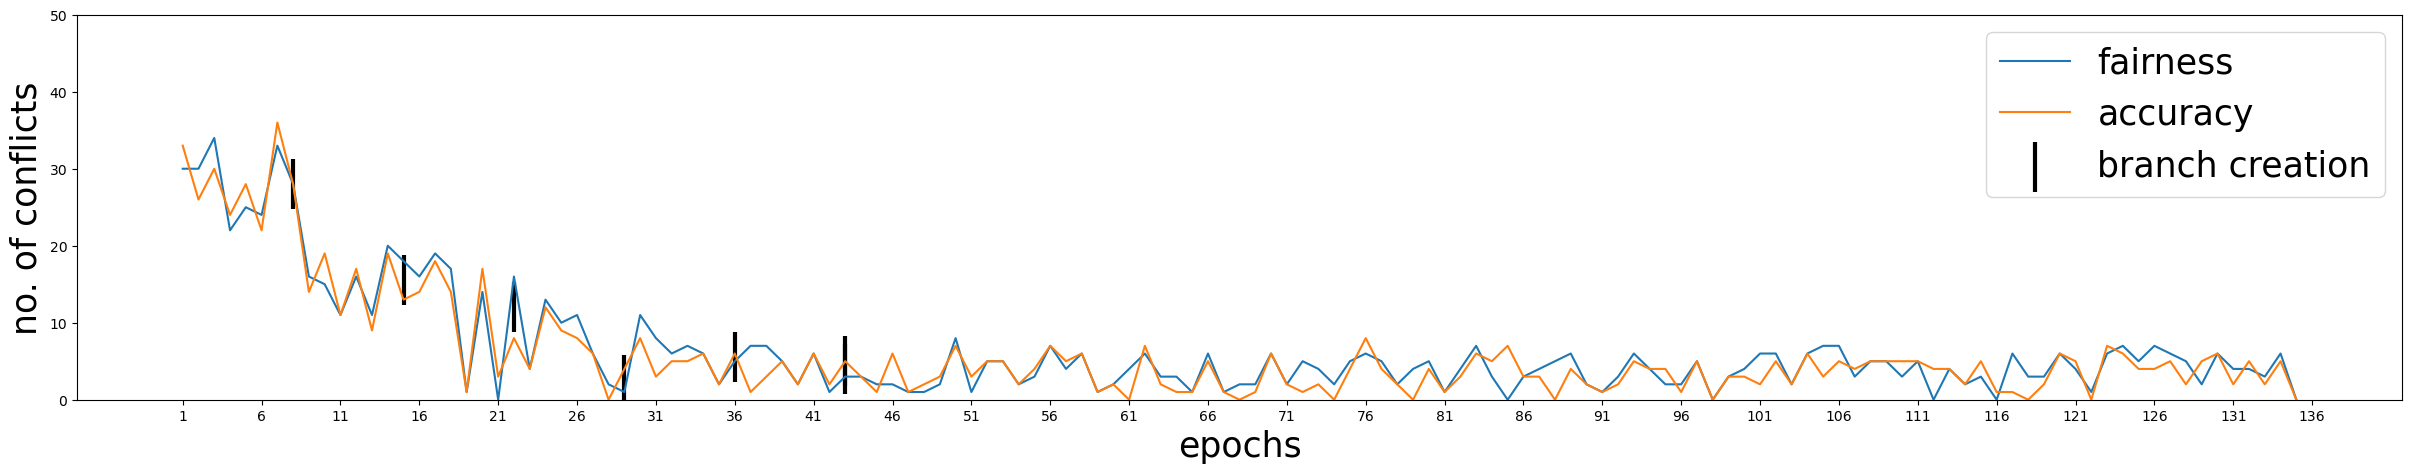

In [76]:
fig, ax = plt.subplots(figsize=(30,5))
plt.ylim(0,50)
lanp=[]
for epoch in range(len(fconflicts)):
    cnf=[]
    for c in fconflicts[epoch]:
        cnf+=c 
    lanp.append(len([v for v in cnf if v>90]))
ax.plot(lanp,label='fairness')
lnp=[]
for epoch in range(len(aconflicts)):
    cnf=[]
    for c in aconflicts[epoch]:
        cnf+=c 
    lnp.append(len([v for v in cnf if v>90]))

#ax.set_ylim(100,500)
ax.plot(lnp,label='accuracy')
for m in range(7,7+5*7+1,7):
    ax.scatter(m,(lnp[m]+lanp[m])/2, marker='|',s=11**3,linewidth=3,color='black')
ax.scatter(m,lnp[m], marker='|',s=11**3,linewidth=3,color='black',label='branch creation')
ax.set_xlabel('epochs',fontsize=25)
ax.set_ylabel('no. of conflicts',fontsize=25)
lb=np.arange(0,136,5)
plt.xticks(lb)
lb=[l+1 for l in lb]
ax.set_xticklabels(lb)
plt.legend(loc='upper right', fontsize=25)
plt.show()

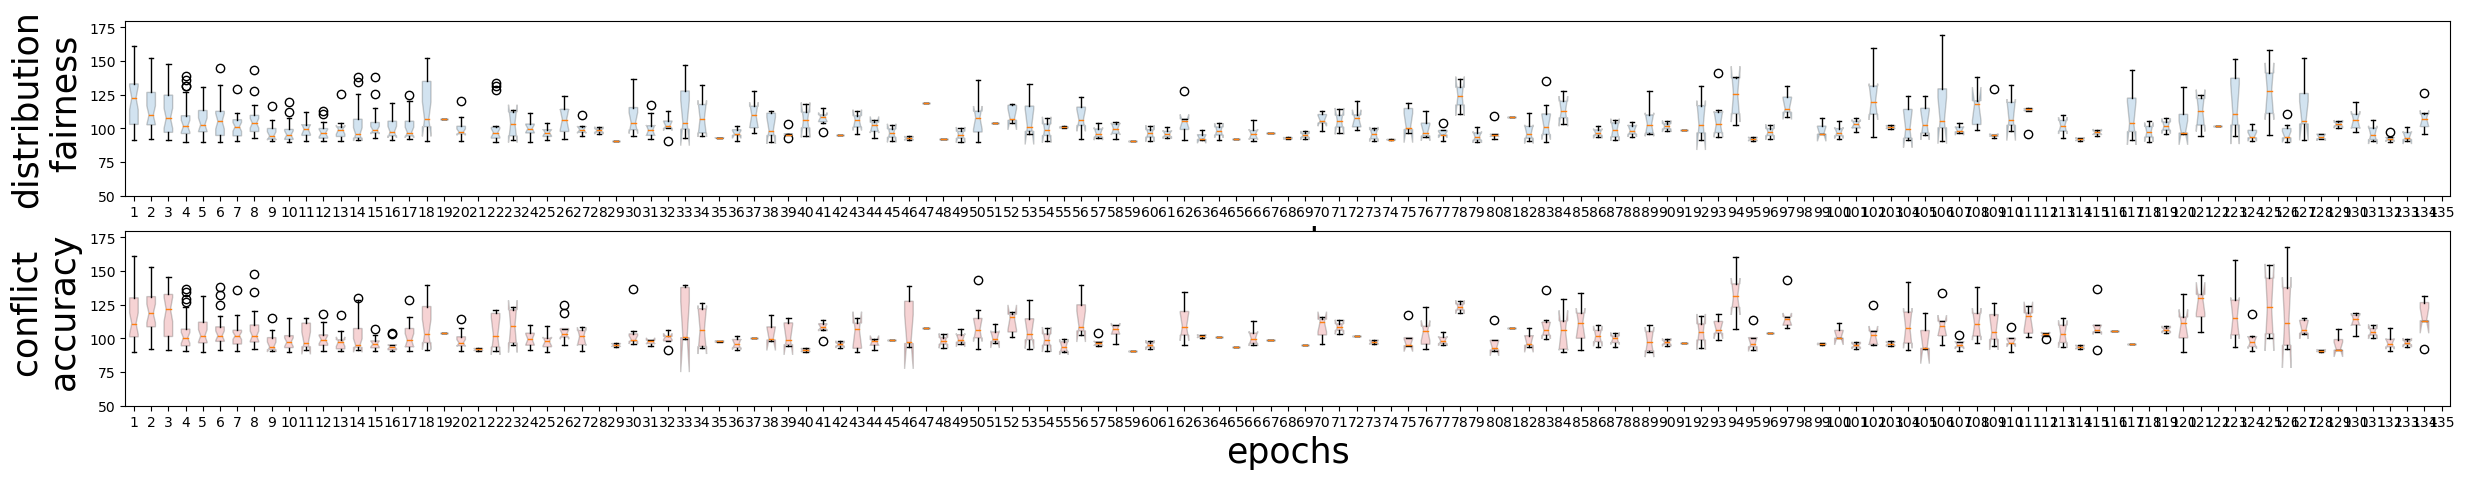

In [78]:
bx_p=[]
for epoch in range(len(fconflicts)):
    cnf=[]
    for c in fconflicts[epoch]:
        cnf+=c 
    bx_p.append([v for v in cnf if v>90])
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,5))
ax[0].set_ylim(50,180)
bp=ax[0].boxplot(bx_p,notch=True, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.2)
    patch.set_facecolor('tab:blue')
ax[0].set_xlabel('epochs',fontsize=25)
ax[0].set_ylabel('distribution\n fairness',fontsize=25)
bx_p=[]
for epoch in range(len(aconflicts)):
    cnf=[]
    for c in aconflicts[epoch]:
        cnf+=c 
    bx_p.append([v for v in cnf if v>90])
#fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,5))
ax[1].set_ylim(50,180)
bp=ax[1].boxplot(bx_p,notch=True, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.2)
    patch.set_facecolor('tab:red')
ax[1].set_xlabel('epochs',fontsize=25)
ax[1].set_ylabel('  conflict \n accuracy',fontsize=25)
#plt.ylabel('conflict distribution',fontsize=25,loc='center')
#plt.yaxis.set_label_coords(-0.1,1.02)

#plt.xticks(np.arange(0,37,5))
#ax.set_xticklabels(np.arange(0,131,5))
plt.show()

In [85]:
f_heat=torch.load(prefix+'f_heat.pt')
a_heat=torch.load(prefix+'a_heat.pt')
Ft,tasks=get_default_meta()

In [104]:
fb19,conflicts,heats=trainFB(year='2019')

State VA
Epoch:  0 Possible groups: [[0, 4], [1], [2], [3]] at Layer 1
Task Employment   Acc: tensor(0.2515) EO: tensor(0.0247) EP: tensor(0.0037)
Task Income   Acc: tensor(0.5955) EO: tensor(0.0132) EP: tensor(0.0074)
Task HealthInsurance   Acc: tensor(0.8813) EO: tensor(0.0182) EP: tensor(0.0169)
Task TravelTime   Acc: tensor(0.5740) EO: tensor(0.0073) EP: tensor(0.0049)
Task IncomePovertyRatio   Acc: tensor(0.8162) EO: tensor(0.0246) EP: tensor(0.0195)
State AL
Epoch:  1 Possible groups: [[0, 2], [1], [3], [4]] at Layer 1
Task Employment   Acc: tensor(0.6121) EO: tensor(0.0272) EP: tensor(0.0022)
Task Income   Acc: tensor(0.6751) EO: tensor(0.0114) EP: tensor(0.0107)
Task HealthInsurance   Acc: tensor(0.8719) EO: tensor(0.0208) EP: tensor(0.0197)
Task TravelTime   Acc: tensor(0.6358) EO: tensor(0.0271) EP: tensor(0.0237)
Task IncomePovertyRatio   Acc: tensor(0.7076) EO: tensor(0.0310) EP: tensor(0.0207)
State IN
Epoch:  2 Possible groups: [[0, 2], [1], [3], [4]] at Layer 1
Task Empl

Epoch:  18 Possible groups: [[0, 2], [1]] at Layer 3
Task Employment   Acc: tensor(0.9784) EO: tensor(0.0097) EP: tensor(0.0008)
Task Income   Acc: tensor(0.6917) EO: tensor(0.0255) EP: tensor(0.0128)
Task HealthInsurance   Acc: tensor(0.8834) EO: tensor(0.0242) EP: tensor(0.0210)
Task TravelTime   Acc: tensor(0.6429) EO: tensor(0.0103) EP: tensor(0.0066)
Task IncomePovertyRatio   Acc: tensor(0.7859) EO: tensor(0.0122) EP: tensor(0.0107)
State WA
Epoch:  19 Possible groups: [[0, 2], [1]] at Layer 3
Task Employment   Acc: tensor(0.9639) EO: tensor(0.0035) EP: tensor(0.0007)
Task Income   Acc: tensor(0.6923) EO: tensor(0.0255) EP: tensor(0.0147)
Task HealthInsurance   Acc: tensor(0.8858) EO: tensor(0.0295) EP: tensor(0.0291)
Task TravelTime   Acc: tensor(0.6329) EO: tensor(0.0004) EP: tensor(0.0002)
Task IncomePovertyRatio   Acc: tensor(0.8077) EO: tensor(0.0050) EP: tensor(0.0035)
State OH
Epoch:  20 Possible groups: [[0, 2], [1]] at Layer 3
Task Employment   Acc: tensor(0.9764) EO: ten

Epoch:  37 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9805) EO: tensor(0.0019) EP: tensor(0.0010)
Task Income   Acc: tensor(0.6967) EO: tensor(0.0292) EP: tensor(0.0133)
Task HealthInsurance   Acc: tensor(0.8623) EO: tensor(0.0118) EP: tensor(0.0072)
Task TravelTime   Acc: tensor(0.7531) EO: tensor(0.0303) EP: tensor(0.0278)
Task IncomePovertyRatio   Acc: tensor(0.7560) EO: tensor(0.0302) EP: tensor(0.0207)
State TX
Epoch:  38 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9897) EO: tensor(0.0048) EP: tensor(0.0002)
Task Income   Acc: tensor(0.7117) EO: tensor(0.0060) EP: tensor(0.0043)
Task HealthInsurance   Acc: tensor(0.8875) EO: tensor(0.0070) EP: tensor(0.0060)
Task TravelTime   Acc: tensor(0.6605) EO: tensor(0.0154) EP: tensor(0.0113)
Task IncomePovertyRatio   Acc: tensor(0.7345) EO: tensor(0.0172) EP: tensor(0.0126)
State FL
Epoch:  39 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9842) EO: tensor(0.005

Epoch:  56 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9791) EO: tensor(0.0143) EP: tensor(0.0011)
Task Income   Acc: tensor(0.7002) EO: tensor(0.0367) EP: tensor(0.0325)
Task HealthInsurance   Acc: tensor(0.8730) EO: tensor(0.0075) EP: tensor(0.0071)
Task TravelTime   Acc: tensor(0.6617) EO: tensor(0.0125) EP: tensor(0.0083)
Task IncomePovertyRatio   Acc: tensor(0.7043) EO: tensor(0.0021) EP: tensor(0.0017)
State MA
Epoch:  57 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9524) EO: tensor(0.0055) EP: tensor(0.0005)
Task Income   Acc: tensor(0.6756) EO: tensor(0.0146) EP: tensor(0.0085)
Task HealthInsurance   Acc: tensor(0.8649) EO: tensor(0.0150) EP: tensor(0.0124)
Task TravelTime   Acc: tensor(0.5983) EO: tensor(0.0108) EP: tensor(0.0068)
Task IncomePovertyRatio   Acc: tensor(0.8489) EO: tensor(0.0023) EP: tensor(0.0009)
State CO
Epoch:  58 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9590) EO: tensor(0.004

Epoch:  75 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9906) EO: tensor(0.0084) EP: tensor(0.0003)
Task Income   Acc: tensor(0.7087) EO: tensor(0.0091) EP: tensor(0.0091)
Task HealthInsurance   Acc: tensor(0.8870) EO: tensor(0.0009) EP: tensor(0.0006)
Task TravelTime   Acc: tensor(0.7068) EO: tensor(0.0053) EP: tensor(0.0013)
Task IncomePovertyRatio   Acc: tensor(0.7336) EO: tensor(0.0149) EP: tensor(0.0106)
State CT
Epoch:  76 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9844) EO: tensor(0.0025) EP: tensor(0.0011)
Task Income   Acc: tensor(0.6860) EO: tensor(0.0503) EP: tensor(0.0223)
Task HealthInsurance   Acc: tensor(0.8816) EO: tensor(0.0489) EP: tensor(0.0402)
Task TravelTime   Acc: tensor(0.7296) EO: tensor(0.0217) EP: tensor(0.0160)
Task IncomePovertyRatio   Acc: tensor(0.8422) EO: tensor(0.0091) EP: tensor(0.0061)
State IL
Epoch:  77 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9863) EO: tensor(0.002

Epoch:  94 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9584) EO: tensor(0.0032) EP: tensor(0.0022)
Task Income   Acc: tensor(0.6919) EO: tensor(0.0178) EP: tensor(0.0139)
Task HealthInsurance   Acc: tensor(0.8697) EO: tensor(0.0157) EP: tensor(0.0154)
Task TravelTime   Acc: tensor(0.5429) EO: tensor(0.0164) EP: tensor(0.0083)
Task IncomePovertyRatio   Acc: tensor(0.7948) EO: tensor(0.0073) EP: tensor(0.0056)
State LA
Epoch:  95 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9826) EO: tensor(0.0053) EP: tensor(0.0006)
Task Income   Acc: tensor(0.6839) EO: tensor(0.0156) EP: tensor(0.0146)
Task HealthInsurance   Acc: tensor(0.8730) EO: tensor(0.0075) EP: tensor(0.0071)
Task TravelTime   Acc: tensor(0.6856) EO: tensor(0.0069) EP: tensor(0.0018)
Task IncomePovertyRatio   Acc: tensor(0.7043) EO: tensor(0.0021) EP: tensor(0.0017)
State IA
Epoch:  96 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9886) EO: tensor(0.012

Epoch:  113 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9855) EO: tensor(0.0056) EP: tensor(0.0003)
Task Income   Acc: tensor(0.7106) EO: tensor(0.0178) EP: tensor(0.0097)
Task HealthInsurance   Acc: tensor(0.8834) EO: tensor(0.0242) EP: tensor(0.0210)
Task TravelTime   Acc: tensor(0.6132) EO: tensor(0.0010) EP: tensor(0.0004)
Task IncomePovertyRatio   Acc: tensor(0.7859) EO: tensor(0.0122) EP: tensor(0.0107)
State LA
Epoch:  114 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9860) EO: tensor(0.0110) EP: tensor(0.0011)
Task Income   Acc: tensor(0.7167) EO: tensor(0.0330) EP: tensor(0.0287)
Task HealthInsurance   Acc: tensor(0.8730) EO: tensor(0.0075) EP: tensor(0.0071)
Task TravelTime   Acc: tensor(0.6959) EO: tensor(0.0056) EP: tensor(0.0019)
Task IncomePovertyRatio   Acc: tensor(0.7043) EO: tensor(0.0021) EP: tensor(0.0017)
State AR
Epoch:  115 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9939) EO: tensor(0.

Epoch:  132 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9794) EO: tensor(0.0017) EP: tensor(0.0012)
Task Income   Acc: tensor(0.7045) EO: tensor(0.0073) EP: tensor(0.0008)
Task HealthInsurance   Acc: tensor(0.8858) EO: tensor(0.0295) EP: tensor(0.0291)
Task TravelTime   Acc: tensor(0.6410) EO: tensor(0.0096) EP: tensor(0.0068)
Task IncomePovertyRatio   Acc: tensor(0.8073) EO: tensor(0.0086) EP: tensor(0.0060)
State CT
Epoch:  133 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9965) EO: tensor(0.0032) EP: tensor(0.0006)
Task Income   Acc: tensor(0.7122) EO: tensor(0.0206) EP: tensor(0.0092)
Task HealthInsurance   Acc: tensor(0.8816) EO: tensor(0.0489) EP: tensor(0.0402)
Task TravelTime   Acc: tensor(0.7125) EO: tensor(0.0116) EP: tensor(0.0101)
Task IncomePovertyRatio   Acc: tensor(0.8422) EO: tensor(0.0091) EP: tensor(0.0061)
State MD
Epoch:  134 Possible groups: [[0], [1]] at Layer 6
Task Employment   Acc: tensor(0.9473) EO: tensor(0.

In [110]:
acc,fair=test_models(fb19,year='2021')

State CA 

Task Employment   Acc: tensor(0.9762) EO: (tensor(0.0185), tensor(0.0031))
Task Income   Acc: tensor(0.7239) EO: (tensor(0.0032), tensor(0.0025))
Task HealthInsurance   Acc: tensor(0.8694) EO: (tensor(0.0033), tensor(0.0029))
Task TravelTime   Acc: tensor(0.6081) EO: (tensor(0.0071), tensor(0.0058))
Task IncomePovertyRatio   Acc: tensor(0.7723) EO: (tensor(0.0069), tensor(0.0040))



State FL 

Task Employment   Acc: tensor(0.9752) EO: (tensor(0.0021), tensor(0.0009))
Task Income   Acc: tensor(0.7054) EO: (tensor(0.0052), tensor(0.0028))
Task HealthInsurance   Acc: tensor(0.8180) EO: (tensor(0.0078), tensor(0.0063))
Task TravelTime   Acc: tensor(0.6080) EO: (tensor(0.0044), tensor(0.0029))
Task IncomePovertyRatio   Acc: tensor(0.7344) EO: (tensor(0.0022), tensor(0.0007))



State GA 

Task Employment   Acc: tensor(0.9752) EO: (tensor(0.0246), tensor(0.0050))
Task Income   Acc: tensor(0.7226) EO: (tensor(0.0175), tensor(0.0111))
Task HealthInsurance   Acc: tensor(0.8719) EO: 

Task Employment   Acc: tensor(0.9690) EO: (tensor(0.0147), tensor(0.0017))
Task Income   Acc: tensor(0.7055) EO: (tensor(0.0161), tensor(0.0119))
Task HealthInsurance   Acc: tensor(0.8780) EO: (tensor(0.0331), tensor(0.0280))
Task TravelTime   Acc: tensor(0.6031) EO: (tensor(0.0161), tensor(0.0144))
Task IncomePovertyRatio   Acc: tensor(0.7652) EO: (tensor(0.0192), tensor(0.0162))



State PA 

Task Employment   Acc: tensor(0.9804) EO: (tensor(0.0036), tensor(0.0004))
Task Income   Acc: tensor(0.7075) EO: (tensor(0.0021), tensor(0.0021))
Task HealthInsurance   Acc: tensor(0.8735) EO: (tensor(0.0041), tensor(0.0027))
Task TravelTime   Acc: tensor(0.5856) EO: (tensor(0.0123), tensor(0.0064))
Task IncomePovertyRatio   Acc: tensor(0.7987) EO: (tensor(0.0097), tensor(0.0078))



State TX 

Task Employment   Acc: tensor(0.9857) EO: (tensor(0.0200), tensor(0.0035))
Task Income   Acc: tensor(0.7271) EO: (tensor(0.0091), tensor(0.0050))
Task HealthInsurance   Acc: tensor(0.8797) EO: (tensor(0.0

In [111]:
relative_avg(acc,fair,year='2021')

tensor(1.0256)
tensor(1.1506)
tensor(1.1424)


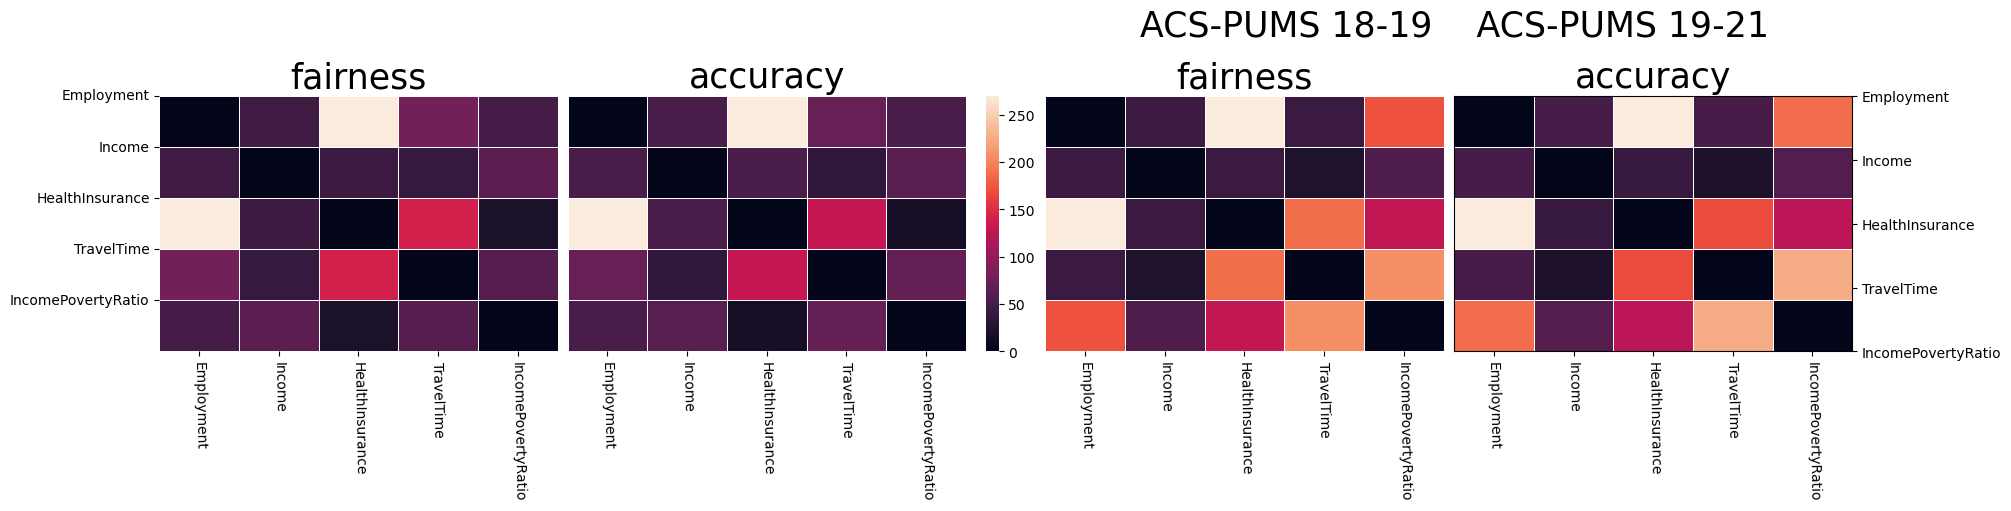

In [127]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(20, 5),layout='constrained')
plt.title('ACS-PUMS 18-19    ACS-PUMS 19-21', x=0, y=1.2,fontsize=25)
ax1 = sns.heatmap(ax=axes[0],data=f_heat, linewidth=0.5,cbar=False)
ax1.set_xticklabels(tasks,rotation=-89)
ax1.set_yticks(np.arange(0,len(f_heat)))
ax1.set_yticklabels(tasks,rotation=-0)
ax1.set_title('fairness',fontsize=25)
ax2 = sns.heatmap(ax=axes[1],data=a_heat, linewidth=0.5)
ax2.set_xticklabels(tasks,rotation=-89)

ax2.set_yticks([])#np.arange(0,len(f_heat)))
#ax2.set_yticklabels(tasks,rotation=-0)
ax2.set_title('accuracy', fontsize=25)

ax3 = sns.heatmap(ax=axes[2],data=heats[0], linewidth=0.5,cbar=False)
ax3.set_xticklabels(tasks,rotation=-89)
ax3.set_yticks([])
ax3.set_title('fairness', fontsize=25)

ax4 = sns.heatmap(ax=axes[3],data=heats[1], linewidth=0.5,cbar=False)
ax4.set_xticklabels(tasks,rotation=-89)
ax4.set_yticks([])
ax4=ax4.twinx()
ax4.set_yticks(np.arange(0,len(f_heat)))

ax4.set_yticklabels([tasks[i] for i in range(len(tasks)-1,-1,-1)],rotation=-0)
ax4.set_title('accuracy', fontsize=25)


plt.show()